In this file we train an LSTM based Deep Learning model using the Document Embeddings obtained from the training of the Summary Text using FastText API.

In [ ]:
# load cleaned data file (adm_ds2.csv) which is obtained after preprocessing

In [ ]:
import os, sys, math, csv, datetime, time, pickle, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
## load csv into a dataframe
df = pd.read_csv('adm_ds2.csv')

In [ ]:
# split the dataset into train and test as 80-20 % respectively
train_x, test_x, train_y, test_y = train_test_split(df.cleaned_text, df.TARGET, random_state=42, test_size=0.2)

In [ ]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((42180,), (10546,), (42180,), (10546,))

In [ ]:
del df

In [ ]:
np.unique(train_y, return_counts=True)

(array([0, 1]), array([40353,  1827]))

In [ ]:
# from here the downsampling process starts

In [ ]:
## separate the train data with target == 1 and target == 0
train0x = train_x[train_y == 0]
train1x = train_x[train_y == 1]

In [ ]:
train0x.shape, train1x.shape

((40353,), (1827,))

In [ ]:
## get the 3 times the data for the majority class to downsample it
## get the data in shuffled form only
indices = np.random.choice(np.arange(train0x.shape[0]), 3*train1x.shape[0])

In [ ]:
# load train vectos for summary features
!cp /content/drive/My\ Drive/train_vectors_cleaned_text_cbow.pkl ./

In [ ]:
## load train vectors from pickled file
with open('train_vectors_cleaned_text_cbow.pkl', 'rb') as fin:
    train_vectors = pickle.load(fin)

In [ ]:
## get the train data feature vectors for the above downsampled shuffled indices
train_x_vectors_0 = train_vectors[train_y == 0][indices]

In [ ]:
train_x_vectors_0.shape, indices.shape

((5481, 100), (5481,))

In [ ]:
## get the train data feature vectors for the minority class
train_x_vectors_1 = train_vectors[train_y == 1]

In [ ]:
## combine the downsampled majority class and all minority class feature vectors
train_x_vectors = np.concatenate([train_x_vectors_0, train_x_vectors_1], axis=0)

In [ ]:
train_x_vectors.shape

(7308, 100)

In [ ]:
## get the corresponding target data values for classifier process
sub_train_y = np.concatenate([[0]*train_x_vectors_0.shape[0], [1]*train_x_vectors_1.shape[0]])

In [ ]:
sub_train_y.shape

(7308,)

In [ ]:
## we train the NaiveBayes Model, XGBoostClassifier
## Deep Learning model on downsampled dataset
## get the AUROC score on the test dataset for each of the model

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
## get the Naive Bayes classifier
nb = GaussianNB()

In [ ]:
np.array(train_vectors).shape

(42180, 100)

In [ ]:
## train the Naive Bayes classifier on the above train data feature vectors
nb.fit(train_x_vectors, sub_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
## load the test data feature vectors
!cp /content/drive/My\ Drive/test_vectors_cleaned_text_cbow.pkl ./

In [ ]:
## load the test data feature vectors from its pickled file
with open('test_vectors_cleaned_text_cbow.pkl', 'rb') as fin:
    test_vectors = pickle.load(fin)

In [ ]:
## get the probability for all the test data feature vectors
nb_preds = nb.predict_proba(test_vectors)

In [ ]:
## get the auroc score
roc_auc_score(test_y, nb_preds[:, 1])

0.6215899128147678

The AUROC score we get for the Naive Bayes classifier is *0.6215899128147678* 


---


Lets compare the score with further classification process

In [ ]:
from xgboost import XGBClassifier

In [ ]:
## load the XGBoost classifier
xgb = XGBClassifier()

In [ ]:
## train teh feature vectors on XGBoost Classifier
xgb.fit(train_x_vectors, sub_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
## get the auroc score on the test dataset for the xgboost classifier
roc_auc_score(test_y, xgb.predict_proba(test_vectors)[:, 1])

0.6690616222622702

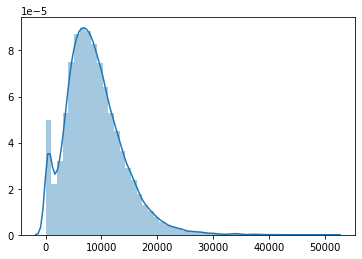

In [ ]:
## plot the length distribution for the current train dataset
sns.distplot([len(x) for x in train_x])

In [ ]:
## get the words in the train dataset
words_train_x = [x.split() for x in train_x]

In [ ]:
## convert it to numpy array
words_train_x = np.array(words_train_x)

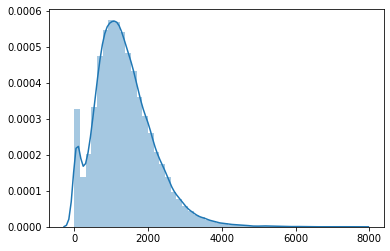

In [ ]:
## plot the number of the words distribution graph for the train dataset
sns.distplot([len(x) for x in words_train_x])

In [ ]:
import gc

In [ ]:
## prepare the train dataset for training of the Deep Learning model LSTM
train_vectors_lstm = np.expand_dims(train_x_vectors, axis=1)

In [ ]:
train_vectors_lstm.shape

(7308, 1, 100)

In [ ]:
## prepare the test dataset for testing of the Deep Learning model LSTM
test_vectors_lstm = np.expand_dims(test_vectors, axis=1)

In [ ]:
test_vectors_lstm.shape

(10546, 1, 100)

In [ ]:
## get the minimum and maximum values of the train vectors
train_vectors_lstm.min(), train_vectors_lstm.max()

(-7.821579456329346, 9.730830192565918)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## get the MinMaxScaler for normalizing the train and test vectors before training and testing the Deep Learning LSTM model
mms = MinMaxScaler(feature_range=(0,1))

In [ ]:
## train the MinMaxScaler object for train dataset and get the scaled features
scaled_train_vectors_lstm = mms.fit_transform(train_vectors_lstm[:, 0, :])

In [ ]:
## prepare the scaled features to be input to the Deep Learning LSTM model
scaled_train_vectors_lstm = np.expand_dims(scaled_train_vectors_lstm, axis=1)

In [ ]:
## transform and prepare the scaled test features for the Deep learning LSTM model
scaled_test_vectors_lstm = np.expand_dims(mms.transform(test_vectors_lstm[:, 0, :]), axis=1)

In [ ]:
## for preparing the Deep Learning LSTM model we use keras library
import keras

Using TensorFlow backend.


In [ ]:
## create the LSTM model
input_tensor = keras.layers.Input(shape=(1, 100))

keras_model = keras.layers.LSTM(90)(input_tensor)

keras_model = keras.layers.Dense(64, activation='relu')(keras_model)

keras_model = keras.layers.Dense(1, activation='sigmoid')(keras_model)

keras_model = keras.models.Model(inputs=[input_tensor], outputs=[keras_model])

keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
keras_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90)                68760     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5824      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 74,649
Trainable params: 74,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## shuffle the dataset
## shuffling the dataset is necessary for Deep Learning based model, so that the training of the Model is proper
## which then gives the correct metrics score

train_shuffle_indices = np.random.permutation(np.arange(scaled_train_vectors_lstm.shape[0]))
shuffled_scaled_train_vectors_lstm = scaled_train_vectors_lstm[train_shuffle_indices]
shuffle_train_y = sub_train_y[train_shuffle_indices]

test_shuffle_indices = np.random.permutation(np.arange(scaled_test_vectors_lstm.shape[0]))
shuffled_scaled_test_vectors_lstm = scaled_test_vectors_lstm[test_shuffle_indices]
suffle_test_y = test_y.values[test_shuffle_indices]

In [ ]:
## train for 100 epochs and test the AUROC score at the end of each epoch
for index in range(100):
  print(keras_model.fit(shuffled_scaled_train_vectors_lstm, shuffle_train_y, batch_size=64))
  print(roc_auc_score(suffle_test_y, keras_model.predict(shuffled_scaled_test_vectors_lstm)[:, 0]))

Epoch 1/1
7308/7308 [==============================] - 0s 63us/step - loss: 0.5158 - acc: 0.7556
0.6749223734839999
Epoch 1/1
7308/7308 [==============================] - 0s 61us/step - loss: 0.5149 - acc: 0.7527
0.6708488586365334
Epoch 1/1
7308/7308 [==============================] - 0s 62us/step - loss: 0.5159 - acc: 0.7515
0.6723111798418653
Epoch 1/1
7308/7308 [==============================] - 0s 56us/step - loss: 0.5210 - acc: 0.7544
0.672800886464371
Epoch 1/1
7308/7308 [==============================] - 0s 61us/step - loss: 0.5162 - acc: 0.7556
0.6642889614079521
Epoch 1/1
7308/7308 [==============================] - 0s 59us/step - loss: 0.5146 - acc: 0.7547
0.6763063578653418
Epoch 1/1
7308/7308 [==============================] - 0s 60us/step - loss: 0.5150 - acc: 0.7555
0.6716953428149303
Epoch 1/1
7308/7308 [==============================] - 0s 58us/step - loss: 0.5157 - acc: 0.7552
0.6622051207117692
Epoch 1/1
7308/7308 [==============================] - 0s 57us/step - los

In [ ]:
## train for yet another 200 epochs and test the loss and accuracy for the test dataset at the end of each epoch
keras_model.fit(shuffled_scaled_train_vectors_lstm, shuffle_train_y, batch_size=256, epochs=200, validation_data=(shuffled_scaled_test_vectors_lstm, suffle_test_y))

Train on 7308 samples, validate on 10546 samples
Epoch 1/200
7308/7308 [==============================] - 0s 54us/step - loss: 0.4858 - acc: 0.7655 - val_loss: 0.3412 - val_acc: 0.9172
Epoch 2/200
7308/7308 [==============================] - 0s 47us/step - loss: 0.4843 - acc: 0.7660 - val_loss: 0.3127 - val_acc: 0.9244
Epoch 3/200
7308/7308 [==============================] - 0s 47us/step - loss: 0.4814 - acc: 0.7674 - val_loss: 0.3091 - val_acc: 0.9295
Epoch 4/200
7308/7308 [==============================] - 0s 45us/step - loss: 0.4819 - acc: 0.7649 - val_loss: 0.3593 - val_acc: 0.8954
Epoch 5/200
7308/7308 [==============================] - 0s 48us/step - loss: 0.4813 - acc: 0.7649 - val_loss: 0.3314 - val_acc: 0.9160
Epoch 6/200
7308/7308 [==============================] - 0s 47us/step - loss: 0.4826 - acc: 0.7693 - val_loss: 0.3496 - val_acc: 0.9196
Epoch 7/200
7308/7308 [==============================] - 0s 49us/step - loss: 0.4820 - acc: 0.7689 - val_loss: 0.3480 - val_acc: 0.9036

In [ ]:
## we obtained the the auroc score of the keras Deep Learning based LSTM model
roc_auc_score(suffle_test_y, keras_model.predict(shuffled_scaled_test_vectors_lstm)[:, 0])

0.6721115832968032